In [1]:
#| default_exp nano_gpt

In [2]:
#| hide
from nbdev.showdoc import *

# Preparing the data

## Opening and Exploring the Data

In [3]:
with open("tinyshakespeare.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(f"length of dataset in characters: {len(text)}")

length of dataset in characters: 1115394


In [4]:
print(f"first 1000 characters of dataset:\n{text[:1000]}")

first 1000 characters of dataset:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for b

## Tokenization

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f"all chars are:{''.join(chars)}")
print(f"vocab size: {vocab_size}")

all chars are:
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [6]:
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {val:key for key, val in stoi.items()}

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

print(encode("Hello, world!"))
print(decode(encode("Hello, world!")))

[20, 43, 50, 50, 53, 6, 1, 61, 53, 56, 50, 42, 2]
Hello, world!


In [7]:
import torch
data = torch.tensor(encode(text), dtype = torch.long)

print(f"data shape: {data.shape}")
print(f"data type: {data.dtype}")

print("-"*50)

print(f"first 100 characters of dataset:\n{data[:100]}")
print(f"first 100 characters of dataset:\n{decode(data[:100].tolist())}")

data shape: torch.Size([1115394])
data type: torch.int64
--------------------------------------------------
first 100 characters of dataset:
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])
first 100 characters of dataset:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## Train Validation Split

In [8]:
n = int(0.9 * len(data))

train_data = data[:n]
val_data = data[n:]

## Create DataLoader

In [9]:
block_size = 8
train_data[:block_size + 1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size + 1]

for t in range(block_size):
    context = x[:t + 1]
    target = y[t]
    print(f"when input tensor is {context.tolist()}, target is {target}")

when input tensor is [18], target is 47
when input tensor is [18, 47], target is 56
when input tensor is [18, 47, 56], target is 57
when input tensor is [18, 47, 56, 57], target is 58
when input tensor is [18, 47, 56, 57, 58], target is 1
when input tensor is [18, 47, 56, 57, 58, 1], target is 15
when input tensor is [18, 47, 56, 57, 58, 1, 15], target is 47
when input tensor is [18, 47, 56, 57, 58, 1, 15, 47], target is 58


In [11]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel
block_size = 8 # what is the maximum context length for predictions?

# number of input_examples = batch_size * block_size (4 * 8 = 32)

def get_batch(split):
    # Select the appropriate dataset based on the split parameter
    data = train_data if split == "train" else val_data

    # Generate a batch of random starting indices within the dataset
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Select a block of text of size block_size starting from each random index
    x = torch.stack([data[i:i+block_size] for i in ix])

    # Shift the selected block of text by one character to the right to create the target sequence
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch("train")
print(f"inputs:\nshape{xb.shape}\ndata: {xb}")
print(f"targets:\nshape{yb.shape}\ndata: {yb}")

inputs:
shapetorch.Size([4, 8])
data: tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
shapetorch.Size([4, 8])
data: tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


# Bigram Language Model
simpleset language model

In [12]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

torch.manual_seed(1337)

## Creating the Model

In [13]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets = None):
        # idx and targets are both (B, T) tensor of ints
        logits = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        
        if targets is None:
            loss = None
        else:
            # note that F.cross_entropy accepts inputs in shape (B, C, T)
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T) # can be as targets = targets.view(-1)
            
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the logits for the next token
            logits, loss = self(idx)
            # focus only on the last time step
            # (note that we are feeding the whole context each time, however we only care about the last prediction)
            # (this make doesn't make sense now, but the function will be modified later)
            logits = logits[:, -1, :] # Becomes (B, C) (get the last time step for each sequence)
            # apply softmax to convert to probabilities
            probs = F.softmax(logits, dim = -1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled token to the context
            idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
        return idx
    

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)

print(f"logits shape: {logits.shape}")
print(f"loss: {loss} | we are expecting a loss of around {torch.log(torch.tensor(vocab_size))}")

logits shape: torch.Size([32, 65])
loss: 4.878634929656982 | we are expecting a loss of around 4.174387454986572


In [14]:
idx = torch.zeros((1,1), dtype = torch.long)
generated = m.generate(idx, 100) # shape (1, 101)
print(decode(generated[0].tolist()))


Sr?qP-QWktXoL&jLDJgOLVz'RIoDqHdhsV&vLLxatjscMpwLERSPyao.qfzs$Ys$zF-w,;eEkzxjgCKFChs!iWW.ObzDnxA Ms$3


## Training the Model

In [15]:
optimizer = torch.optim.AdamW(m.parameters(), lr = 1e-3)
batch_size = 32
lossi = []

for i in range(10000):
    # sample a batch of training data
    xb, yb = get_batch("train")

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()

    lossi.append(loss.item())

print(f"loss: {loss.item()}")

loss: 2.5727508068084717


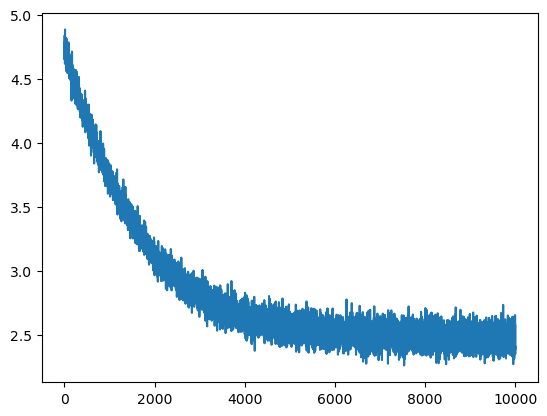

In [16]:
plt.plot(lossi);

In [17]:
# sampling from the model
idx = torch.zeros((1,1), dtype = torch.long)
generated = m.generate(idx, 400) # shape (1, 101)
print(decode(generated[0].tolist()))


Iyoteng h hasbe pave pirance
Rie hicomyonthar's
Plinseard ith henoure wounonthioneir thondy, y heltieiengerofo'dsssit ey
KIN d pe wither vouprrouthercc.
hathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so it t jod weancotha:
h hay.JUCle n prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZAnde.
athave l.
KEONH:
ARThanco be y,-hedarwnoddy scace, tridesar, wnl'shenou


## Porting our code to a script
check `bigram.py`

In [18]:
!python3 bigram.py -h

usage: bigram.py [-h] [--batch_size BATCH_SIZE] [--block_size BLOCK_SIZE]
                 [--max_iters MAX_ITERS] [--eval_interval EVAL_INTERVAL]
                 [--learning_rate LEARNING_RATE] [--eval_iters EVAL_ITERS]
                 [--n_embed N_EMBED] [--n_layer N_LAYER] [--n_head N_HEAD]
                 [--dropout DROPOUT]

Process some integers.

options:
  -h, --help            show this help message and exit
  --batch_size BATCH_SIZE
                        how many independent sequences will we process in
                        parallel (default: 4)
  --block_size BLOCK_SIZE
                        what is the maximum context length for predictions?
                        (default: 8)
  --max_iters MAX_ITERS
                        how many training iterations do we want? (default:
                        3000)
  --eval_interval EVAL_INTERVAL
                        how often do we evaluate the loss on train and val?
                        (default: 300)
  --learning_ra

In [20]:
!python3 bigram.py

0.209729 M parameters
 step 0 | train loss: 4.4116 | val loss: 4.4048
 step 100 | train loss: 2.6539 | val loss: 2.6605
 step 200 | train loss: 2.5140 | val loss: 2.5161
 step 300 | train loss: 2.4039 | val loss: 2.4126
 step 400 | train loss: 2.3430 | val loss: 2.3506
 step 500 | train loss: 2.2918 | val loss: 2.3002
 step 600 | train loss: 2.2347 | val loss: 2.2517
 step 700 | train loss: 2.1930 | val loss: 2.2089
 step 800 | train loss: 2.1556 | val loss: 2.1793
 step 900 | train loss: 2.1211 | val loss: 2.1507
 step 1000 | train loss: 2.0768 | val loss: 2.1179
 step 1100 | train loss: 2.0615 | val loss: 2.1029
 step 1200 | train loss: 2.0300 | val loss: 2.0744
 step 1300 | train loss: 2.0145 | val loss: 2.0577
 step 1400 | train loss: 1.9936 | val loss: 2.0542
 step 1500 | train loss: 1.9759 | val loss: 2.0375
 step 1600 | train loss: 1.9503 | val loss: 2.0281
 step 1700 | train loss: 1.9273 | val loss: 2.0172
 step 1800 | train loss: 1.9151 | val loss: 2.0030
 step 1900 | train lo

# Self Attention Trick (Averaging the previous tokens embeddings)

- We need each token commuinicate with all previous tokens, for example: the 5th token communicate with 1st, 2nd, 3rd, 4th tokens
- Since we are predicting the next token, we need to consider the previous tokens only
- The easiset way to make them communicate is averaging the previous tokens embeddings (it's kinda lossy since we are losing the spatial information)

## Using Explicit loops 

In [21]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2 # batch size, time, channels
x = torch.randn(B, T, C)
print(f"x shape: {x.shape}")

# We want x[b, t] = mean_(i<=t) x[b, i]
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (t, C)
        xbow[b, t] = torch.mean(xprev, dim = 0) # average over time dimension (t)

x shape: torch.Size([4, 8, 2])


In [22]:
# Let's Check the first Batch
print(f"x[0]: {x[0]}")
print(f"xbow[0]: {xbow[0]}")

# the first row is the same 
print(x[0, 0] == xbow[0, 0])
# the second row is the average of the first two rows
print((x[0, 0] + x[0, 1]) / 2 == xbow[0, 1])
# etc ...

x[0]: tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])
xbow[0]: tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])
tensor([True, True])
tensor([True, True])


## Using Matrix Multiplication
- Instead of nested loops, we can make it using matrix multiplication
- This can be done by multiplying the matrix with lower triangular matrix

In [23]:
torch.manual_seed(42)
# lower triangular matrix of ones
a = torch.tril(torch.ones(3,3)) 
# make all rows sum to 1
a = a / torch.sum(a, 1, keepdim = True)
# create a random matrix
b = torch.randint(0, 10, (3, 2)).float() 

c = a @ b
print(f"a (shape = {a.shape}) =\n{a}")
print(f"b (shape = {b.shape}) =\n{b}")
print(f"c (shape = {c.shape}) =\n{c}")

a (shape = torch.Size([3, 3])) =
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b (shape = torch.Size([3, 2])) =
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c (shape = torch.Size([3, 2])) =
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [24]:
# We want x[b, t] = mean_(i<=t) x[b, i]
wei = torch.tril(torch.ones(T, T)) # (T, T)
# make all rows sum to 1
wei = wei / torch.sum(wei, 1, keepdim = True) # (T, T)
xbow2 = wei @ x # (T, T) @ (B, T, C) ----broadcasting----> (B, T, T) @ (B, T, C) ➡️ (B, T, C)

# check if xbow2 is the same as xbow
print(torch.allclose(xbow, xbow2, atol = 1e-7))

True


## Using Softmax

In [25]:
tril = torch.tril(torch.ones(T, T))
# we start with zeros, but later these will be replaced with data dependent values (affinities)
wei = torch.zeros((T, T))
# masked_fill: for all elements where tril == 0, replace with float("-inf")
wei = wei.masked_fill(tril == 0, float("-inf"))
print(f"wei:\n{wei}")
wei = F.softmax(wei, dim = -1)
print(f"wei:\n{wei}")
xbow3 = wei @ x

# check if xbow3 is the same as xbow
print(torch.allclose(xbow, xbow3, atol = 1e-7))

wei:
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
wei:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
True

# Minor Code Cleanup
(These modifications are done in `bigram.py`)


## Adding variable embedding size
1. Removing vocab_size from the constructor of `BigramLanguageModel` class, since it's already defiend above
2. Modifying the embedding layer to has an output size of `n_embed` instead of `vocab_size`
3. Adding a linear layer with `vocab_size` outputs after the embedding layer

In [26]:
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # the output layer is a linear layer with vocab_size outputs
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets = None):
        # idx and targets are both (B, T) tensor of ints
        token_emb = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        logits = self.lm_head(token_emb) # (B, T, vocab_size) = (4, 8, vocab_size)
    
    # rest of the code ..

## Positional Encoding
1. Adding a positional encoding layer to the model `self.position_embedding_table`
2. Adding the positional encoding to the input embeddings `x = token_emb + pos_emb`

In [27]:
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # the output layer is a linear layer with vocab_size outputs
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets = None):
        B, T = idx.shape
        # idx and targets are both (B, T) tensor of ints
        token_emb = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        pos_emb = self.position_embedding_table(torch.arange(T, device = idx.device)) # (T, C) = (8, vocab_size)
        # x has the token identities + the position embeddings
        x = token_emb + pos_emb # (B, T, C) = (4, 8, vocab_size)
        logits = self.lm_head(x) # (B, T, vocab_size) = (4, 8, vocab_size)
    
    # rest of the code ..

# Self Attention
Consider his as `version 4 ` of part 3

## Previous code from part 3

In [28]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels
x = torch.randn(B, T, C)

tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim = -1)

out = wei @ x

print(f"tril:\n{tril}")
print(f"wei:\n{wei}")
print(f"out.shape:\n{out.shape}")


tril:
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
wei:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
out.shape:
torch.Size([4, 8, 32])


## Building the Self-Attention
Each token (can be called node too) at each position emmits 2 vectors:
1. Query: What I'm looking for?
2. Key: What do I contain?
3. Value: What I will tell you or the information I have `in this head`?
    
- Affinities between tokens `wei` = my Query @ all Keys
- If key and query are aligned ➡️ high value ➡️ learn more about this sequence
- Instead of multiplying wei with tokens directly, we multiply it with values (which is the information we want to learn about)

In [29]:
torch.manual_seed(1337)
B, T, C = 4, 8, 32 # batch, time, channels

# x is private information of each token
x = torch.randn(B, T, C)

# single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias = False)
query = nn.Linear(C, head_size, bias = False)
value = nn.Linear(C, head_size, bias = False)


k = key(x) # (B, T, head_size) = (4, 8, 16)
q = query(x) # (B, T, head_size) = (4, 8, 16)

# now every token in every batch is associated with a key and a query (in parallel), no communication between tokens has happened yet

wei = q @ k.transpose(-2, -1) # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
tril = torch.tril(torch.ones(T, T))
# wei are no longer zeros, but data dependent values (affinities)
# wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim = -1)

print(f"wei[0]: {wei[0]}")

# multiply with value instead of x
v = value(x) # (B, T, head_size) = (4, 8, 16)
out = wei @ v # (B, T, T) @ (B, T, head_size) = (B, T, head_size)
# out = wei @ x


wei[0]: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)


## Notes About Self Attention

1. Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

2. There is no notion of space. Attention simply acts over a set of vectors. **This is why we need to positionally encode tokens.**

3. Each example across batch dimension is of course processed completely **independently** and **never "talk" to each other**

4. In an `encoder` attention block just delete the single line that does masking with `tril`, **allowing all tokens to communicate**, it can be used for some applications like translation and sentiment analysis. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like **language modeling**.

5. `self-attention` just means that the **keys** and **values** are **produced from the same source** as **queries**. In "cross-attention", the **queries** still get produced from **x**, but the **keys** and **values** come from some other, external source (e.g. an **encoder** module)

6. `Scaled Dot-Product Attention`: $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$

    `Scaled` attention additional divides `wei` by $\frac{1}{\sqrt{\text{head\_size}}}$. This makes it so when input `Q`, `K` are unit variance, `wei` will be **unit variance** too and Softmax will stay diffuse and **not saturate** too much. it's important especially in initialization.

    if the **variance** is **very high**, **softmax** will **converge** to **one-hot vector**

In [30]:
# Scaled Attention
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)

print("Unscaled Attention")
wei = q @ k.transpose(-2, -1)
print(f"var(k) = {torch.var(k)}")
print(f"var(q) = {torch.var(q)}")
print(f"var(wei) = {torch.var(wei)}")

print("\nScaled Attention")
wei = q @ k.transpose(-2, -1) * (head_size ** -0.5)
print(f"var(k) = {torch.var(k)}")
print(f"var(q) = {torch.var(q)}")
print(f"var(wei) = {torch.var(wei)}")

Unscaled Attention
var(k) = 1.044861912727356
var(q) = 1.0700464248657227
var(wei) = 17.46897315979004

Scaled Attention
var(k) = 1.044861912727356
var(q) = 1.0700464248657227
var(wei) = 1.0918108224868774


## Adding single Self Attention Head to the Bigram Language Model

### Making new `Head` class

In [31]:
# Making the Head Class
class Head(nn.Module):
    """ one head of self attention """
    
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias = False)
        self.query = nn.Linear(n_embed, head_size, bias = False)
        self.value = nn.Linear(n_embed, head_size, bias = False)
        # since tril isn't a parameter, we register it as a buffer
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
    
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B, T, C)
        q = self.query(x) # (B, T, C)

        # compute attention scores (affinities)
        wei = q @ k.transpose(-2, -1) * (C ** -0.5) # (B, T, C) @ (B, C, T) = (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0 , float("-inf")) # (B, T, T)
        wei = F.softmax(wei, dim = -1) # (B, T, T)

        # perform weighted aggregation of the values
        v = self.value(x) # (B, T, C)
        out = wei @ v # (B, T, T) @ (B, T, C) = (B, T, C)
        return out

### Modifying `BigramLanguageModel` class
1. Adding `Head` to the `BigramLanguageModel` class
2. Adding `Head` to the `BigramLanguageModel` forward pass
3. For `generate` function, we need crop idx to keep `idx.shape <= block_size`, since we are using `positional embedding`

In [32]:
# Adding Head to the BigramLanguageModel

# super simple bigram model
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # a single head of self attention
        self.sa_head = Head(n_embed)
        # the output layer is a linear layer with vocab_size outputs
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets = None):
        B, T = idx.shape
        # idx and targets are both (B, T) tensor of ints
        token_emb = self.token_embedding_table(idx) # (B, T, C) = (4, 8 , vocab_size)
        pos_emb = self.position_embedding_table(torch.arange(T, device = idx.device)) # (T, C) = (8, vocab_size)
        # x has the token identities + the position embeddings
        x = token_emb + pos_emb # (B, T, C) = (4, 8, vocab_size)
        # feed the input to the self attention head
        x = self.sa_head(x) # (B, T, C) = (4, 8, vocab_size)
        logits = self.lm_head(x) # (B, T, vocab_size) = (4, 8, vocab_size)

        if targets is None:
            loss = None
        else:
            # note that F.cross_entropy accepts inputs in shape (B, C, T)
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T) # can be as targets = targets.view(-1)
            
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:] # (B, T)
            # get the logits for the next token
            logits, loss = self(idx_cond)
            # focus only on the last time step
            # (note that we are feeding the whole context each time, however we only care about the last prediction)
            # (this make doesn't make sense now, but the function will be modified later)
            logits = logits[:, -1, :] # Becomes (B, C) (get the last time step for each sequence)
            # apply softmax to convert to probabilities
            probs = F.softmax(logits, dim = -1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled token to the context
            idx = torch.cat((idx, idx_next), dim = 1) # (B, T + 1)
        return idx

### Testing
(loss is `2.54` instead of `2.57`)

In [33]:
!python3 bigram.py --eval_interval 2999

0.209729 M parameters
 step 0 | train loss: 4.4116 | val loss: 4.4048
 step 2999 | train loss: 1.7879 | val loss: 1.9086

And they bride.

NUTHORD IV:
Kind Petice you each graves the can
he art third wear he. Warwithry ane away, my feans
acut onour
Yourself fittice of my helige, at mirters,
I in latiHer drove to does me none
And justs like die; like us, courmby:
Aughtainst, why. Here, she royal elsed whom
Is would that
And insun her evices to thee, and The chiress poor
of his burder hands thy fis are
In the flownd male of would Prive my of.

HENRY BOLON:
Prisabardand the Eart to uncles.

DUCHASS III:
My hand for hi


## Multi-Head Attention
- Make the new `MultiHeadAttention` class

In [34]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_head)])
    
    def forward(self, x):
        # concatenate them into the channel dimension
        return torch.cat([h(x) for h in self.heads], dim = -1)

then add it to `BigramLanguageModel` class 

previously:
```python
self.sa_head = Head(n_embed)
```
now:
```python
self.sa_heads = MultiHeadAttention(num_head = 4, head_size = n_embed // 4)
```

### Testing
(loss is `2.51` instead of `2.54`)

In [35]:
!python3 bigram.py --eval_interval 2999

0.209729 M parameters
 step 0 | train loss: 4.4116 | val loss: 4.4048
 step 2999 | train loss: 1.7879 | val loss: 1.9086

And they bride.

NUTHORD IV:
Kind Petice you each graves the can
he art third wear he. Warwithry ane away, my feans
acut onour
Yourself fittice of my helige, at mirters,
I in latiHer drove to does me none
And justs like die; like us, courmby:
Aughtainst, why. Here, she royal elsed whom
Is would that
And insun her evices to thee, and The chiress poor
of his burder hands thy fis are
In the flownd male of would Prive my of.

HENRY BOLON:
Prisabardand the Eart to uncles.

DUCHASS III:
My hand for hi


# Adding FeedForward Layer 
The feedforward is applied to each token independently

In [36]:
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_embed),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.net(x)

# Then add it to forward of the BigramLanguageModel

``` python
# previous code ..
x = self.sa_heads(x) # (B, T, C) = (4, 8, vocab_size)
# feed the output of the self attention head to the feed forward layer
x = self.ff(x) # (B, T, C) = (4, 8, vocab_size)
logits = self.lm_head(x) # (B, T, vocab_size) = (4, 8, vocab_size)
# rest of the code ..
```

## Test
(loss is `2.46` instead of `2.51`)

In [37]:
!python3 bigram.py --eval_interval 2999

0.209729 M parameters
 step 0 | train loss: 4.4116 | val loss: 4.4048
 step 2999 | train loss: 1.7879 | val loss: 1.9086

And they bride.

NUTHORD IV:
Kind Petice you each graves the can
he art third wear he. Warwithry ane away, my feans
acut onour
Yourself fittice of my helige, at mirters,
I in latiHer drove to does me none
And justs like die; like us, courmby:
Aughtainst, why. Here, she royal elsed whom
Is would that
And insun her evices to thee, and The chiress poor
of his burder hands thy fis are
In the flownd male of would Prive my of.

HENRY BOLON:
Prisabardand the Eart to uncles.

DUCHASS III:
My hand for hi


# Residual Connections

## Stacking the Blocks

In [38]:
class Block(nn.Module):
    """ Transformer Block: Communication followed by Computation """

    def __init__(self, n_embed, n_head):
        """ n_embed: embedding dimension
            n_head: number of heads in the multi-head attention
        """
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
    
    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

``` python
# previous code ..
# each token directly reads off the logits for the next token from a loockup table
self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
# each position is also associated with an embedding vector
self.position_embedding_table = nn.Embedding(block_size, n_embed)
# transformer blocks
self.blocks = nn.Sequential(
        Block(n_embed, n_head = 4),
        Block(n_embed, n_head = 4),
        Block(n_embed, n_head = 4),
)
self.lm_head = nn.Linear(n_embed, vocab_size)
# rest of the code ..
```

Add them in the forward pass

``` python
# previous code ..
x = token_emb + pos_emb # (B, T, C) = (4, 8, vocab_size)
# feed the input to the self attention head
x = self.blocks(x) # (B, T, C) = (4, 8, vocab_size)
logits = self.lm_head(x) # (B, T, vocab_size) = (4, 8, vocab_size)
# rest of the code ..
```

### Test
(loss is `2.81` instead of `2.46`) ➡️ **WORSE**

In [39]:
!python3 bigram.py --eval_interval 2999

0.209729 M parameters
 step 0 | train loss: 4.4116 | val loss: 4.4048
 step 2999 | train loss: 1.7879 | val loss: 1.9086

And they bride.

NUTHORD IV:
Kind Petice you each graves the can
he art third wear he. Warwithry ane away, my feans
acut onour
Yourself fittice of my helige, at mirters,
I in latiHer drove to does me none
And justs like die; like us, courmby:
Aughtainst, why. Here, she royal elsed whom
Is would that
And insun her evices to thee, and The chiress poor
of his burder hands thy fis are
In the flownd male of would Prive my of.

HENRY BOLON:
Prisabardand the Eart to uncles.

DUCHASS III:
My hand for hi


## Adding Residual Connections (Skip Connections)

### Transformer Block

In [40]:
class Block(nn.Module):
    """ Transformer Block: Communication followed by Computation """

    def __init__(self, n_embed, n_head):
        """ n_embed: embedding dimension
            n_head: number of heads in the multi-head attention
        """
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
    
    def forward(self, x):
        # residual connection (add the input to the output)
        x = x + self.sa(x)
        x = x + self.ffwd(x)
        return x

### Multi-Head Attention

In [41]:
# Multi Head Attention Class
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_head)])
        # linear transformation to the output of the multi-head attention as projection back to the residual pathway
        self.proj = nn.Linear(n_embed, n_embed)
    
    def forward(self, x):
        # out is the outptu of the multi-head attention
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        # apply a linear layer to the concatenated output
        out = self.proj(out)
        return out

### FeedForward Layer

In [42]:
# Feed Forward Class
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            # multiply by 4 to follow the original implementation
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(n_embed * 4, n_embed),
        )
    
    def forward(self, x):
        return self.net(x)

### Test
(loss is `2.33` instead of `2.81` and `2.46` before it)

In [43]:
!python3 bigram.py --eval_interval 2999 

0.209729 M parameters
 step 0 | train loss: 4.4116 | val loss: 4.4048
 step 2999 | train loss: 1.7879 | val loss: 1.9086

And they bride.

NUTHORD IV:
Kind Petice you each graves the can
he art third wear he. Warwithry ane away, my feans
acut onour
Yourself fittice of my helige, at mirters,
I in latiHer drove to does me none
And justs like die; like us, courmby:
Aughtainst, why. Here, she royal elsed whom
Is would that
And insun her evices to thee, and The chiress poor
of his burder hands thy fis are
In the flownd male of would Prive my of.

HENRY BOLON:
Prisabardand the Eart to uncles.

DUCHASS III:
My hand for hi


# LayerNorm

## BatchNorm1d from makemore part 3

In [44]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained while running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim= True)
            # batch variance
            xvar = x.var(0, keepdim= True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers in training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

# columns are normalized
print(f"mean of first column: {x[:, 0].mean():.4f} | std of first column: {x[:, 0].std():.4f}")
# rows are not normalized ➡️ we need to normalize the rows instead
print(f"mean of first row: {x[0, :].mean():.4f} | std of first row: {x[0, :].std():.4f}")

mean of first column: 0.0000 | std of first column: 1.0000
mean of first row: 0.0411 | std of first row: 1.0431


In [45]:
# after normalizing the rows (and removing the buffers too)
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim= True)
        xvar = x.var(1, keepdim= True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

torch.manual_seed(1337)
module = BatchNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

# columns are not normalized now
print(f"mean of first column: {x[:, 0].mean():.4f} | std of first column: {x[:, 0].std():.4f}")
# rows are normalized now
print(f"mean of first row: {x[0, :].mean():.4f} | std of first row: {x[0, :].std():.4f}")

mean of first column: 0.1469 | std of first column: 0.8803
mean of first row: -0.0000 | std of first row: 1.0000


## Adding LayerNorm

### In the Transformer Blocks

In [46]:
class Block(nn.Module):
    """ Transformer Block: Communication followed by Computation """

    def __init__(self, n_embed, n_head):
        """ n_embed: embedding dimension
            n_head: number of heads in the multi-head attention
        """
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        # ln1 is applied directly on input before the multi-head attention
        self.ln1 = nn.LayerNorm(n_embed)
        # ln2 is applied directly on the output of the multi-head attention before the feed-forward layer
        self.ln2 = nn.LayerNorm(n_embed)
    
    def forward(self, x):
        # residual connection (add the input to the output)
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

### After all blocks (before last linear layer)

In [47]:
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # transformer blocks
        self.blocks = nn.Sequential(
                Block(n_embed, n_head = 4),
                Block(n_embed, n_head = 4),
                Block(n_embed, n_head = 4),
                # add layernorm here
                nn.LayerNorm(n_embed),
        )
        self.lm_head = nn.Linear(n_embed, vocab_size)

# Scaling up the model

## Adding `n_layer` variable

In [48]:
# super simple bigram model
class BigramLanguageModel(nn.Module):
    # no need to pass vocab_size as an argument, since it is a global variable in this file
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a loockup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # each position is also associated with an embedding vector
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        # transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embed, n_head = 4) for _ in range(n_layer)])
        # Remember to add it in forward too
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

## Adding Dropouts
- In `Head` after calculating `wei`
- In `MultiHeadAttention` after `self.proj`
- In `FeedForward` after last linear

## Try

In [49]:
!python3 bigram.py

0.209729 M parameters
 step 0 | train loss: 4.4116 | val loss: 4.4048
 step 100 | train loss: 2.6539 | val loss: 2.6605
 step 200 | train loss: 2.5140 | val loss: 2.5161
 step 300 | train loss: 2.4039 | val loss: 2.4126
 step 400 | train loss: 2.3430 | val loss: 2.3506
 step 500 | train loss: 2.2918 | val loss: 2.3002
 step 600 | train loss: 2.2347 | val loss: 2.2517
 step 700 | train loss: 2.1930 | val loss: 2.2089
 step 800 | train loss: 2.1556 | val loss: 2.1793
 step 900 | train loss: 2.1211 | val loss: 2.1507
 step 1000 | train loss: 2.0768 | val loss: 2.1179
 step 1100 | train loss: 2.0615 | val loss: 2.1029
 step 1200 | train loss: 2.0300 | val loss: 2.0744
 step 1300 | train loss: 2.0145 | val loss: 2.0577
 step 1400 | train loss: 1.9936 | val loss: 2.0542
 step 1500 | train loss: 1.9759 | val loss: 2.0375
 step 1600 | train loss: 1.9503 | val loss: 2.0281
 step 1700 | train loss: 1.9273 | val loss: 2.0172
 step 1800 | train loss: 1.9151 | val loss: 2.0030
 step 1900 | train lo

In [50]:
#| hide
import nbdev; nbdev.nbdev_export()